# Comparative Analysis of All Models for d-t Pair

This notebook analyzes and compares results from all trained models for d-t phoneme classification:
- **Hybrid CNN+MLP V3** (from `03.1_d-t_improved_hybrid_cnn_mlp_with_context.ipynb`)
- **Hybrid CNN+MLP V4** (from `03.2_d-t_improved_hybrid_cnn_mlp_v4_with_context.ipynb`)
- **Hybrid CNN+MLP V4 Optimized** (from `03.2.2_d-t_improved_hybrid_cnn_mlp_v4_optimized.ipynb`)
- **Classical ML Models** (from `03.3_ML_d-t_classification.ipynb`)

For each model, we will:
1. Load predictions and metrics
2. Create confusion matrices
3. Compare performance metrics across models
4. Analyze probability distributions
5. Identify best performing model


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Project root
PROJECT_ROOT = Path('/Volumes/SSanDisk/SpeechRec-German')

# Define paths for all models
MODELS_CONFIG = {
    'V3': {
        'name': 'Hybrid CNN+MLP V3',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context' / 'improved_models' / 'hybrid_cnn_mlp_v3_with_context' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context' / 'improved_models' / 'hybrid_cnn_mlp_v3_with_context' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context' / 'features' / 'features.parquet'
    },
    'V4': {
        'name': 'Hybrid CNN+MLP V4',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_with_context_v2' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_with_context_v2' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'features' / 'features.parquet'
    },
    'V4_Optimized': {
        'name': 'Hybrid CNN+MLP V4 Optimized',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_2_optimized' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_2_optimized' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'features' / 'features.parquet'
    },
    'ML_Models': {
        'name': 'Classical ML Models',
        'type': 'machine_learning',
        'results_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'ml_results' / 'all_results.json',
        'results_csv_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'ml_results' / 'all_results.csv',
        'features_path': PROJECT_ROOT / 'artifacts' / 'd-t_dl_models_with_context_v2' / 'features' / 'features.parquet'
    }
}

# Class labels for d-t pair
CLASS_0 = 'd'
CLASS_1 = 't'

print("Configuration loaded successfully!")
print(f"\nAnalyzing {len(MODELS_CONFIG)} model groups:")
for model_key, config in MODELS_CONFIG.items():
    print(f"  - {config['name']} ({config['type']})")


Configuration loaded successfully!

Analyzing 4 model groups:
  - Hybrid CNN+MLP V3 (deep_learning)
  - Hybrid CNN+MLP V4 (deep_learning)
  - Hybrid CNN+MLP V4 Optimized (deep_learning)
  - Classical ML Models (machine_learning)


## Part 1: Load Data for All Models


In [ ]:
# Load data for all deep learning models
all_predictions = {}
all_metrics = {}

print("="*80)
print("LOADING DATA FOR ALL MODELS")
print("="*80)

# Load Deep Learning models
for model_key, config in MODELS_CONFIG.items():
    if config['type'] == 'deep_learning':
        print(f"\nLoading {config['name']}...")
        try:
            # Load predictions
            if config['predictions_path'].exists():
                predictions_df = pd.read_csv(config['predictions_path'])
                all_predictions[model_key] = predictions_df
                print(f"  ✓ Loaded {len(predictions_df)} predictions")
                print(f"    Correct: {predictions_df['is_correct'].sum()}, Incorrect: {(~predictions_df['is_correct'].astype(bool)).sum()}")
            else:
                print(f"  ✗ Predictions file not found: {config['predictions_path']}")
                continue
            
            # Load metrics
            if config['metrics_path'].exists():
                with open(config['metrics_path'], 'r') as f:
                    metrics = json.load(f)
                all_metrics[model_key] = metrics
                print(f"  ✓ Loaded metrics:")
                print(f"    Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
            else:
                print(f"  ✗ Metrics file not found: {config['metrics_path']}")
        except Exception as e:
            print(f"  ✗ Error loading {config['name']}: {e}")

# Load ML models results
print(f"\nLoading {MODELS_CONFIG['ML_Models']['name']}...")
try:
    if MODELS_CONFIG['ML_Models']['results_path'].exists():
        with open(MODELS_CONFIG['ML_Models']['results_path'], 'r') as f:
            ml_results = json.load(f)
        all_metrics['ML_Models'] = ml_results
        print(f"  ✓ Loaded results for {len(ml_results)} ML models")
        
        # Load CSV for detailed analysis
        if MODELS_CONFIG['ML_Models']['results_csv_path'].exists():
            ml_results_df = pd.read_csv(MODELS_CONFIG['ML_Models']['results_csv_path'])
            print(f"  ✓ Loaded detailed results CSV")
    else:
        print(f"  ✗ ML results file not found: {MODELS_CONFIG['ML_Models']['results_path']}")
except Exception as e:
    print(f"  ✗ Error loading ML models: {e}")

print(f"\n{'='*80}")
print(f"Successfully loaded {len(all_predictions)} deep learning models and {1 if 'ML_Models' in all_metrics else 0} ML model group")
print(f"{'='*80}")


LOADING DATA FOR ALL MODELS

Loading Hybrid CNN+MLP V3...
  ✓ Loaded 19949 predictions
    Correct: 19151, Incorrect: 798
  ✓ Loaded metrics:
    Accuracy: 0.9600, F1: 0.9600, ROC-AUC: 0.9915

Loading Hybrid CNN+MLP V4...
  ✓ Loaded 19949 predictions
    Correct: 19096, Incorrect: 853
  ✓ Loaded metrics:
    Accuracy: 0.9572, F1: 0.9573, ROC-AUC: 0.9908

Loading Hybrid CNN+MLP V4 Optimized...
  ✓ Loaded 19949 predictions
    Correct: 19095, Incorrect: 854
  ✓ Loaded metrics:
    Accuracy: 0.9572, F1: 0.9572, ROC-AUC: 0.9907

Loading Classical ML Models...
  ✗ ML results file not found: /Volumes/SSanDisk/SpeechRec-German/artifacts/d-t_dl_models_with_context_v2/ml_results/all_results.json

Successfully loaded 3 deep learning models and 0 ML model group


## Part 2: Comparative Performance Analysis


In [ ]:
# Create comparison dataframe for all models
comparison_data = []

# Add Deep Learning models
for model_key, metrics in all_metrics.items():
    if model_key != 'ML_Models':
        comparison_data.append({
            'Model': MODELS_CONFIG[model_key]['name'],
            'Type': 'Deep Learning',
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ROC-AUC': metrics['roc_auc'],
            'Precision_d': metrics.get('precision_d', metrics.get('precision_per_class', [0, 0])[0]),
            'Precision_t': metrics.get('precision_t', metrics.get('precision_per_class', [0, 0])[1]),
            'Recall_d': metrics.get('recall_d', metrics.get('recall_per_class', [0, 0])[0]),
            'Recall_t': metrics.get('recall_t', metrics.get('recall_per_class', [0, 0])[1]),
            'F1_d': metrics.get('f1_d', metrics.get('f1_per_class', [0, 0])[0]),
            'F1_t': metrics.get('f1_t', metrics.get('f1_per_class', [0, 0])[1])
        })

# Add best ML model
if 'ML_Models' in all_metrics and 'ml_results_df' in locals():
    best_ml = ml_results_df.iloc[0]  # Already sorted by test_f1_weighted
    comparison_data.append({
        'Model': f"ML: {best_ml['model_name']}",
        'Type': 'Machine Learning',
        'Accuracy': best_ml['test_accuracy'],
        'F1-Score': best_ml['test_f1_weighted'],
        'Precision': best_ml['test_precision'],
        'Recall': best_ml['test_recall'],
        'ROC-AUC': best_ml.get('test_roc_auc', np.nan),
        'Precision_d': np.nan,
        'Precision_t': np.nan,
        'Recall_d': np.nan,
        'Recall_t': np.nan,
        'F1_d': np.nan,
        'F1_t': np.nan
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("="*80)
print("PERFORMANCE COMPARISON ACROSS ALL MODELS")
print("="*80)
print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model['Model']}")
print(f"{'='*80}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print(f"ROC-AUC: {best_model['ROC-AUC']:.4f}")


PERFORMANCE COMPARISON ACROSS ALL MODELS

                      Model          Type  Accuracy  F1-Score  Precision   Recall  ROC-AUC  Precision_d  Precision_t  Recall_d  Recall_t     F1_d     F1_t
          Hybrid CNN+MLP V3 Deep Learning  0.959998  0.960002   0.960009 0.959998 0.991526     0.954014     0.964812  0.956164  0.963070 0.955088 0.963940
          Hybrid CNN+MLP V4 Deep Learning  0.957241  0.957258   0.957297 0.957241 0.990821     0.947987     0.964611  0.955224  0.958826 0.951592 0.961709
Hybrid CNN+MLP V4 Optimized Deep Learning  0.957191  0.957240   0.957500 0.957191 0.990662     0.940902     0.970540  0.963199  0.952470 0.951920 0.961420

BEST MODEL: Hybrid CNN+MLP V3
Accuracy: 0.9600
F1-Score: 0.9600
ROC-AUC: 0.9915


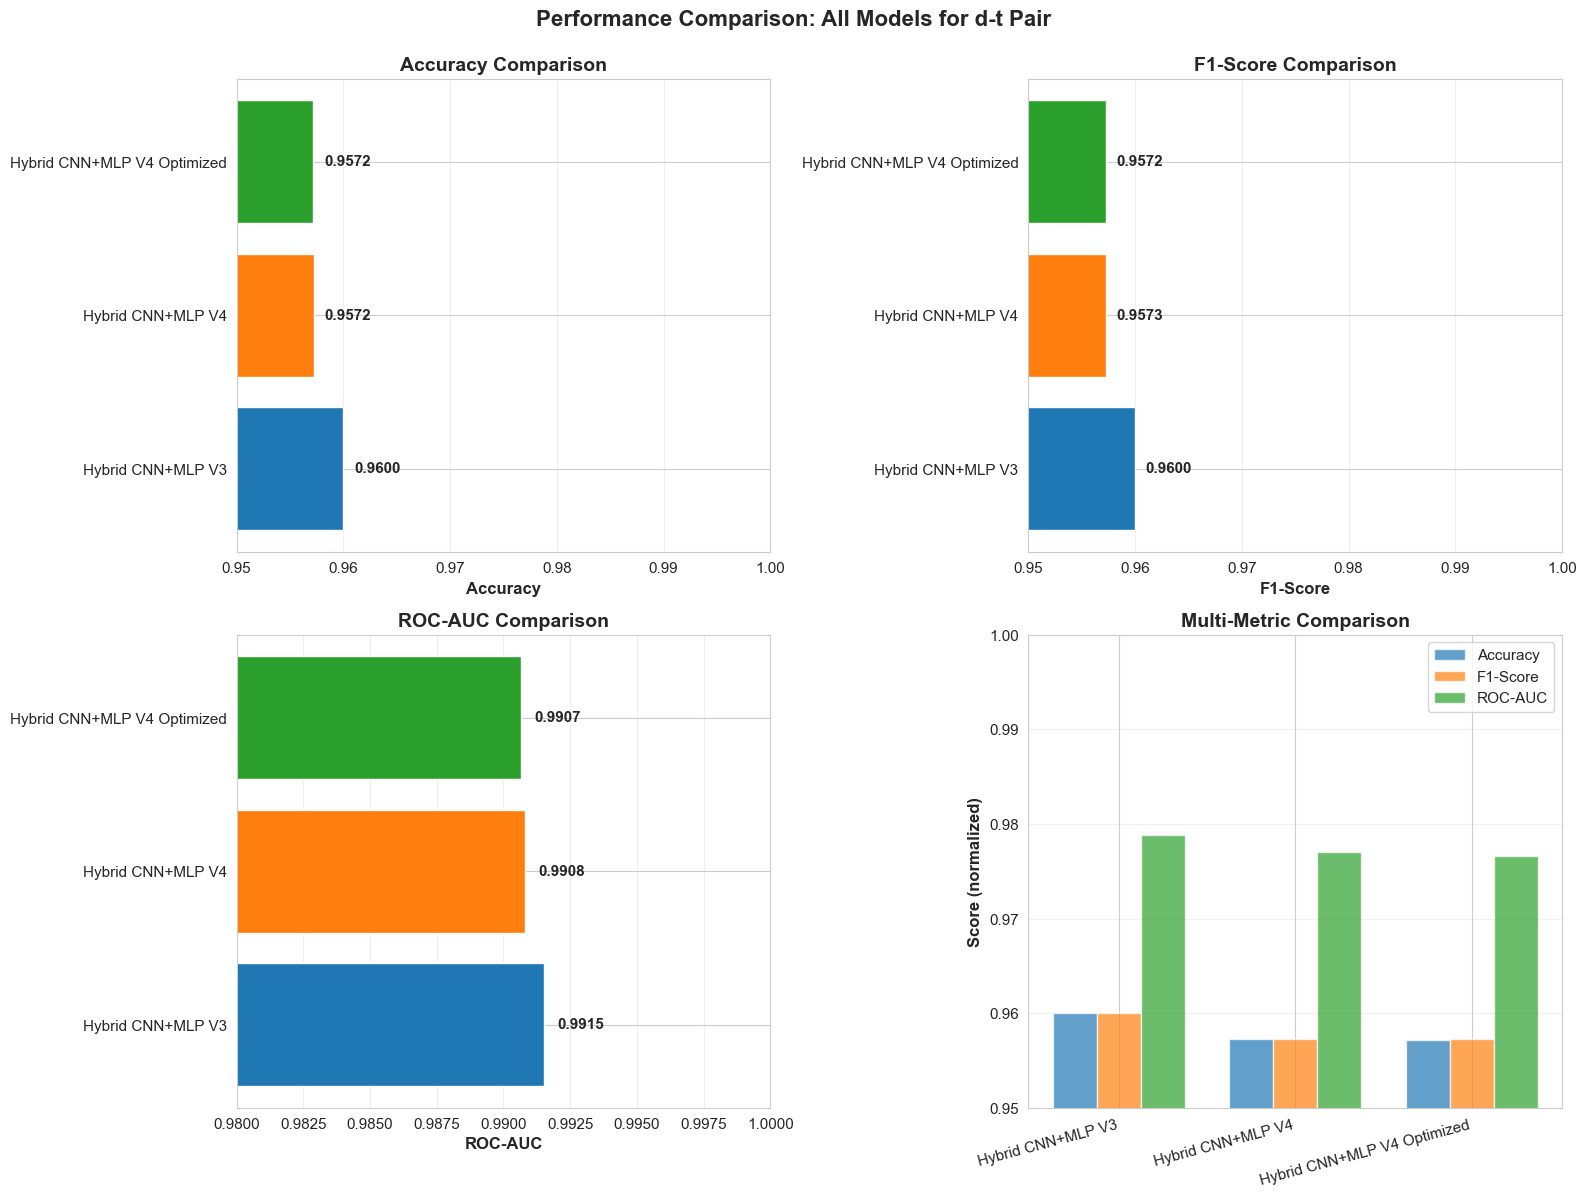

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color=colors[:len(comparison_df)])
ax1.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
ax1.set_xlim([0.95, 1.0])
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, acc) in enumerate(zip(bars, comparison_df['Accuracy'])):
    ax1.text(acc + 0.001, i, f'{acc:.4f}', va='center', fontweight='bold')

# 2. F1-Score comparison
ax2 = axes[0, 1]
bars = ax2.barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors[:len(comparison_df)])
ax2.set_xlabel('F1-Score', fontweight='bold', fontsize=12)
ax2.set_title('F1-Score Comparison', fontweight='bold', fontsize=14)
ax2.set_xlim([0.95, 1.0])
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, f1) in enumerate(zip(bars, comparison_df['F1-Score'])):
    ax2.text(f1 + 0.001, i, f'{f1:.4f}', va='center', fontweight='bold')

# 3. ROC-AUC comparison
ax3 = axes[1, 0]
bars = ax3.barh(comparison_df['Model'], comparison_df['ROC-AUC'], color=colors[:len(comparison_df)])
ax3.set_xlabel('ROC-AUC', fontweight='bold', fontsize=12)
ax3.set_title('ROC-AUC Comparison', fontweight='bold', fontsize=14)
ax3.set_xlim([0.98, 1.0])
ax3.grid(True, alpha=0.3, axis='x')
for i, (bar, roc) in enumerate(zip(bars, comparison_df['ROC-AUC'])):
    if not pd.isna(roc):
        ax3.text(roc + 0.0005, i, f'{roc:.4f}', va='center', fontweight='bold')

# 4. Multi-metric radar chart (simplified as grouped bar)
ax4 = axes[1, 1]
x = np.arange(len(comparison_df))
width = 0.25
metrics_to_plot = ['Accuracy', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].values
    # Normalize ROC-AUC for comparison (scale to 0.95-1.0 range)
    if metric == 'ROC-AUC':
        values = 0.95 + (values - 0.98) * (0.05 / 0.02) if not pd.isna(values).all() else values
    ax4.bar(x + idx*width, values, width, label=metric, alpha=0.7)
ax4.set_ylabel('Score (normalized)', fontweight='bold', fontsize=12)
ax4.set_title('Multi-Metric Comparison', fontweight='bold', fontsize=14)
ax4.set_xticks(x + width)
ax4.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax4.legend()
ax4.set_ylim([0.95, 1.0])
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Performance Comparison: All Models for d-t Pair', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Part 3: Confusion Matrices for All Deep Learning Models


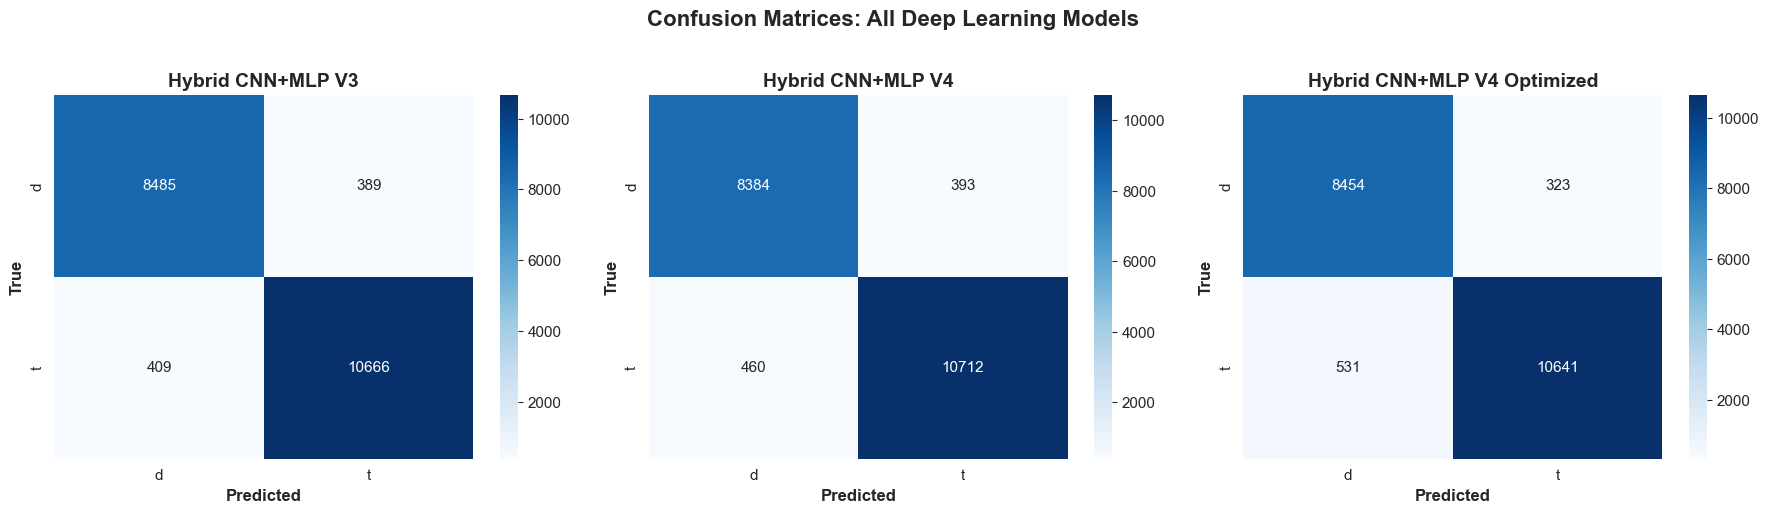

CLASSIFICATION REPORTS

Hybrid CNN+MLP V3:
------------------------------------------------------------
              precision    recall  f1-score   support

           d     0.9540    0.9562    0.9551      8874
           t     0.9648    0.9631    0.9639     11075

    accuracy                         0.9600     19949
   macro avg     0.9594    0.9596    0.9595     19949
weighted avg     0.9600    0.9600    0.9600     19949


Hybrid CNN+MLP V4:
------------------------------------------------------------
              precision    recall  f1-score   support

           d     0.9480    0.9552    0.9516      8777
           t     0.9646    0.9588    0.9617     11172

    accuracy                         0.9572     19949
   macro avg     0.9563    0.9570    0.9567     19949
weighted avg     0.9573    0.9572    0.9573     19949


Hybrid CNN+MLP V4 Optimized:
------------------------------------------------------------
              precision    recall  f1-score   support

           d   

In [ ]:
# Create confusion matrices for all deep learning models
n_models = len(all_predictions)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for idx, (model_key, predictions_df) in enumerate(all_predictions.items()):
    ax = axes[idx]
    y_true = predictions_df['true_class_encoded'].values
    y_pred = predictions_df['predicted_class_encoded'].values
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[CLASS_0, CLASS_1],
                yticklabels=[CLASS_0, CLASS_1])
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('True', fontsize=12, fontweight='bold')
    ax.set_title(f'{MODELS_CONFIG[model_key]["name"]}', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrices: All Deep Learning Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print classification reports
print("="*80)
print("CLASSIFICATION REPORTS")
print("="*80)
for model_key, predictions_df in all_predictions.items():
    print(f"\n{MODELS_CONFIG[model_key]['name']}:")
    print("-" * 60)
    y_true = predictions_df['true_class_encoded'].values
    y_pred = predictions_df['predicted_class_encoded'].values
    print(classification_report(y_true, y_pred, 
                                target_names=[CLASS_0, CLASS_1],
                                digits=4))


## Part 4: Probability Distribution Analysis


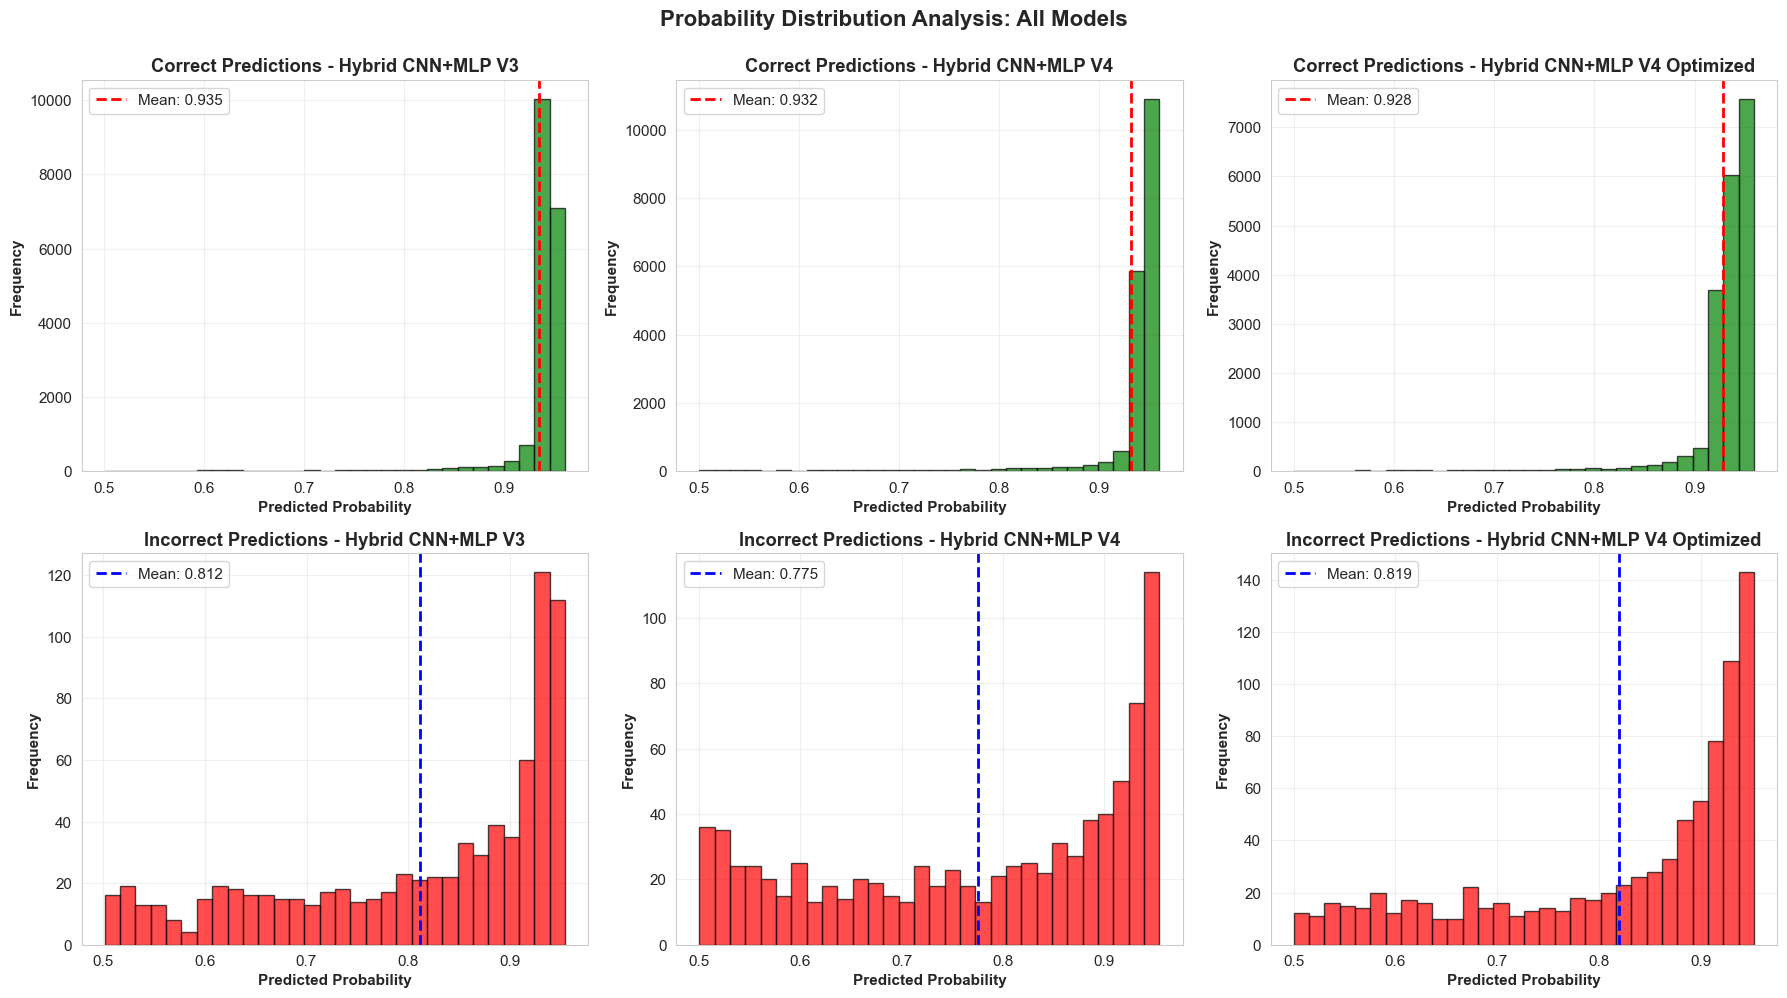

PROBABILITY STATISTICS COMPARISON

Hybrid CNN+MLP V3:
  Correct predictions:
    Mean: 0.9349, Median: 0.9414, Std: 0.0445
  Incorrect predictions:
    Mean: 0.8121, Median: 0.8627, Std: 0.1350
  Separation: 0.1228

Hybrid CNN+MLP V4:
  Correct predictions:
    Mean: 0.9321, Median: 0.9457, Std: 0.0573
  Incorrect predictions:
    Mean: 0.7751, Median: 0.8139, Std: 0.1500
  Separation: 0.1570

Hybrid CNN+MLP V4 Optimized:
  Correct predictions:
    Mean: 0.9285, Median: 0.9321, Std: 0.0453
  Incorrect predictions:
    Mean: 0.8194, Median: 0.8782, Std: 0.1337
  Separation: 0.1091


In [ ]:
# Compare probability distributions across models
n_models = len(all_predictions)
fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

if n_models == 1:
    axes = axes.reshape(2, 1)

for idx, (model_key, predictions_df) in enumerate(all_predictions.items()):
    # Top row: Correct predictions
    ax1 = axes[0, idx]
    correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
    ax1.hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
    ax1.axvline(correct_probs.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {correct_probs.mean():.3f}')
    ax1.set_xlabel('Predicted Probability', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title(f'Correct Predictions - {MODELS_CONFIG[model_key]["name"]}', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom row: Incorrect predictions
    ax2 = axes[1, idx]
    incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
    ax2.hist(incorrect_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
    ax2.axvline(incorrect_probs.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {incorrect_probs.mean():.3f}')
    ax2.set_xlabel('Predicted Probability', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title(f'Incorrect Predictions - {MODELS_CONFIG[model_key]["name"]}', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.suptitle('Probability Distribution Analysis: All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statistics comparison
print("="*80)
print("PROBABILITY STATISTICS COMPARISON")
print("="*80)
for model_key, predictions_df in all_predictions.items():
    correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
    incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
    
    print(f"\n{MODELS_CONFIG[model_key]['name']}:")
    print(f"  Correct predictions:")
    print(f"    Mean: {correct_probs.mean():.4f}, Median: {np.median(correct_probs):.4f}, Std: {correct_probs.std():.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Mean: {incorrect_probs.mean():.4f}, Median: {np.median(incorrect_probs):.4f}, Std: {incorrect_probs.std():.4f}")
    print(f"  Separation: {correct_probs.mean() - incorrect_probs.mean():.4f}")


## Part 5: Error Analysis


ERROR ANALYSIS COMPARISON

                      Model  Total Errors  Error Rate %  High Conf Errors  High Conf Errors %  Low Conf Errors  Low Conf Errors %  Errors d  Error Rate d %  Errors t  Error Rate t %
          Hybrid CNN+MLP V3           798      4.000201               500           62.656642               84          10.526316       389        4.383593       409        3.693002
          Hybrid CNN+MLP V4           853      4.275904               453           53.106682              167          19.577960       393        4.477612       460        4.117436
Hybrid CNN+MLP V4 Optimized           854      4.280916               564           66.042155              100          11.709602       323        3.680073       531        4.752954


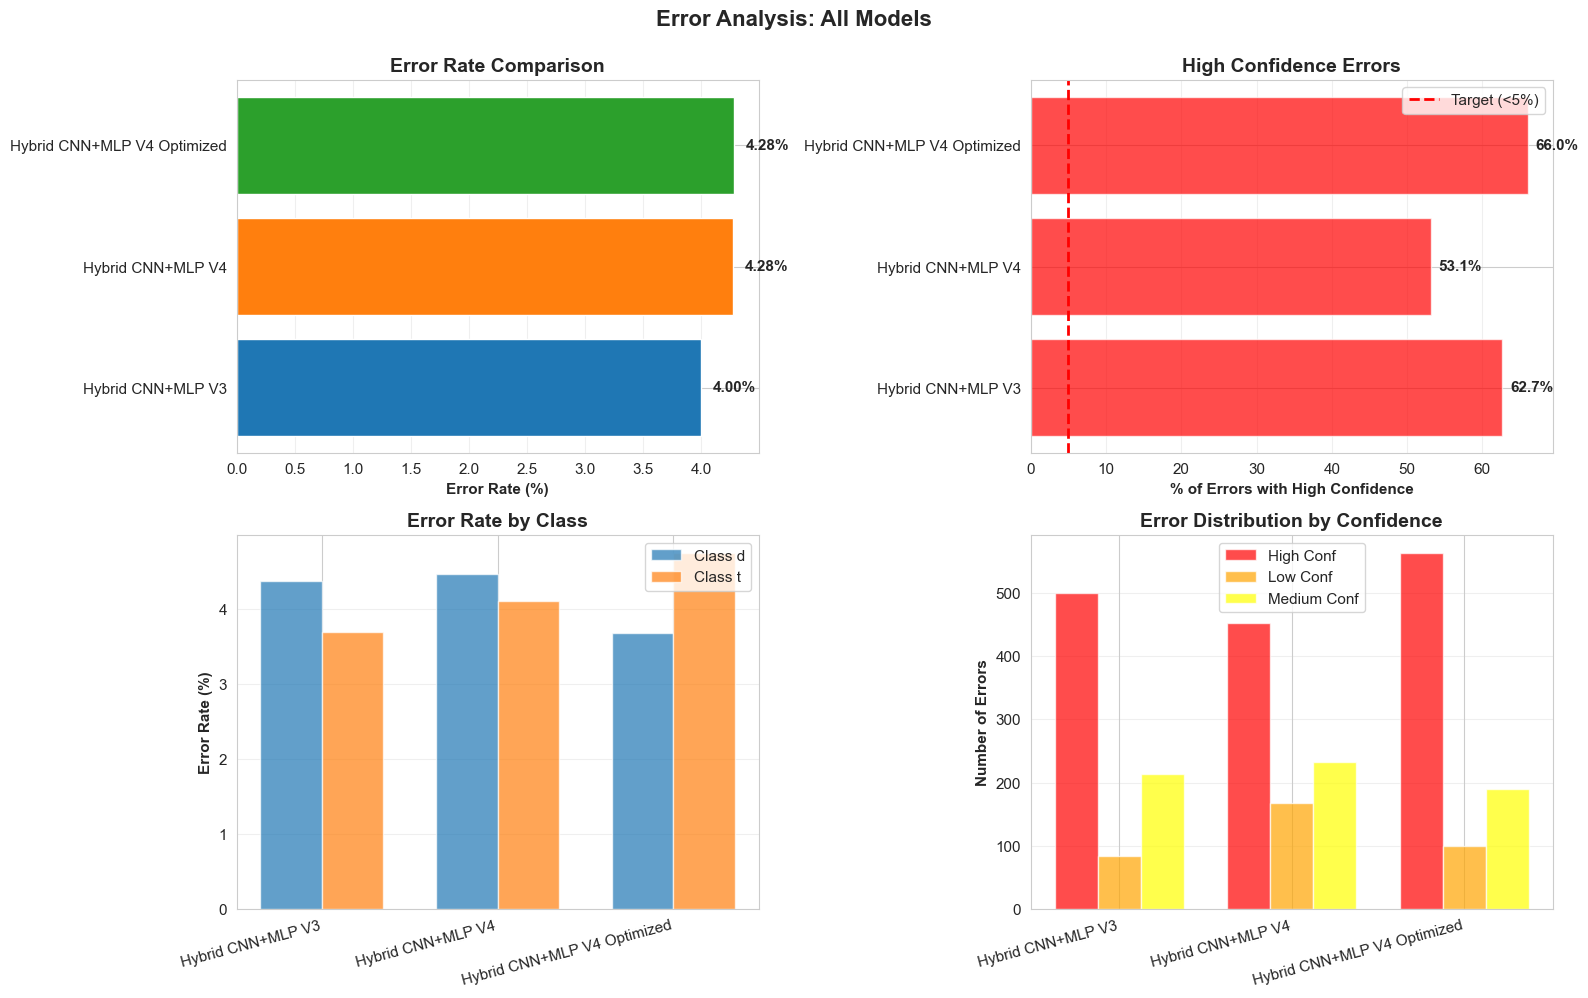

In [ ]:
# Error analysis for all models
error_analysis_data = []

for model_key, predictions_df in all_predictions.items():
    total = len(predictions_df)
    errors = (~predictions_df['is_correct'].astype(bool)).sum()
    error_rate = errors / total
    
    # High confidence errors (>0.8)
    high_conf_errors = ((predictions_df['is_correct'] == 0) & (predictions_df['max_prob'] > 0.8)).sum()
    high_conf_error_pct = (high_conf_errors / errors * 100) if errors > 0 else 0
    
    # Low confidence errors (<0.6)
    low_conf_errors = ((predictions_df['is_correct'] == 0) & (predictions_df['max_prob'] < 0.6)).sum()
    low_conf_error_pct = (low_conf_errors / errors * 100) if errors > 0 else 0
    
    # Errors by class
    errors_by_class = {}
    for class_label in [CLASS_0, CLASS_1]:
        class_errors = ((predictions_df['true_class'] == class_label) & 
                       (predictions_df['is_correct'] == 0)).sum()
        class_total = (predictions_df['true_class'] == class_label).sum()
        errors_by_class[class_label] = {
            'count': class_errors,
            'total': class_total,
            'rate': (class_errors / class_total * 100) if class_total > 0 else 0
        }
    
    error_analysis_data.append({
        'Model': MODELS_CONFIG[model_key]['name'],
        'Total Errors': errors,
        'Error Rate %': error_rate * 100,
        'High Conf Errors': high_conf_errors,
        'High Conf Errors %': high_conf_error_pct,
        'Low Conf Errors': low_conf_errors,
        'Low Conf Errors %': low_conf_error_pct,
        f'Errors {CLASS_0}': errors_by_class[CLASS_0]['count'],
        f'Error Rate {CLASS_0} %': errors_by_class[CLASS_0]['rate'],
        f'Errors {CLASS_1}': errors_by_class[CLASS_1]['count'],
        f'Error Rate {CLASS_1} %': errors_by_class[CLASS_1]['rate']
    })

error_analysis_df = pd.DataFrame(error_analysis_data)

print("="*80)
print("ERROR ANALYSIS COMPARISON")
print("="*80)
print("\n" + error_analysis_df.to_string(index=False))

# Visualize error analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Error rates
ax1 = axes[0, 0]
bars = ax1.barh(error_analysis_df['Model'], error_analysis_df['Error Rate %'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(error_analysis_df)])
ax1.set_xlabel('Error Rate (%)', fontweight='bold')
ax1.set_title('Error Rate Comparison', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, rate) in enumerate(zip(bars, error_analysis_df['Error Rate %'])):
    ax1.text(rate + 0.1, i, f'{rate:.2f}%', va='center', fontweight='bold')

# 2. High confidence errors
ax2 = axes[0, 1]
bars = ax2.barh(error_analysis_df['Model'], error_analysis_df['High Conf Errors %'],
                color='red', alpha=0.7)
ax2.set_xlabel('% of Errors with High Confidence', fontweight='bold')
ax2.set_title('High Confidence Errors', fontweight='bold', fontsize=14)
ax2.axvline(5, color='red', linestyle='--', linewidth=2, label='Target (<5%)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, pct) in enumerate(zip(bars, error_analysis_df['High Conf Errors %'])):
    ax2.text(pct + 1, i, f'{pct:.1f}%', va='center', fontweight='bold')

# 3. Error rates by class
ax3 = axes[1, 0]
x = np.arange(len(error_analysis_df))
width = 0.35
bars1 = ax3.bar(x - width/2, error_analysis_df[f'Error Rate {CLASS_0} %'], width,
               label=f'Class {CLASS_0}', alpha=0.7)
bars2 = ax3.bar(x + width/2, error_analysis_df[f'Error Rate {CLASS_1} %'], width,
               label=f'Class {CLASS_1}', alpha=0.7)
ax3.set_ylabel('Error Rate (%)', fontweight='bold')
ax3.set_title('Error Rate by Class', fontweight='bold', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(error_analysis_df['Model'], rotation=15, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Error distribution
ax4 = axes[1, 1]
x = np.arange(len(error_analysis_df))
width = 0.25
ax4.bar(x - width, error_analysis_df['High Conf Errors'], width,
       label='High Conf', color='red', alpha=0.7)
ax4.bar(x, error_analysis_df['Low Conf Errors'], width,
       label='Low Conf', color='orange', alpha=0.7)
ax4.bar(x + width, error_analysis_df['Total Errors'] - 
       error_analysis_df['High Conf Errors'] - error_analysis_df['Low Conf Errors'], width,
       label='Medium Conf', color='yellow', alpha=0.7)
ax4.set_ylabel('Number of Errors', fontweight='bold')
ax4.set_title('Error Distribution by Confidence', fontweight='bold', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(error_analysis_df['Model'], rotation=15, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Error Analysis: All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [ ]:
# Display ML models comparison if available
if 'ml_results_df' in locals() and len(ml_results_df) > 0:
    print("="*80)
    print("CLASSICAL ML MODELS COMPARISON")
    print("="*80)
    
    # Select relevant columns
    ml_display = ml_results_df[['model_name', 'test_accuracy', 'test_f1_weighted', 
                                'test_precision', 'test_recall', 'test_roc_auc']].copy()
    ml_display = ml_display.sort_values('test_f1_weighted', ascending=False)
    ml_display.columns = ['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
    
    print("\n" + ml_display.to_string(index=False))
    
    # Visualize top ML models
    top_ml = ml_display.head(10)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Accuracy
    ax1 = axes[0, 0]
    bars = ax1.barh(top_ml['Model'], top_ml['Accuracy'], color='steelblue', alpha=0.7)
    ax1.set_xlabel('Accuracy', fontweight='bold')
    ax1.set_title('Top 10 ML Models - Accuracy', fontweight='bold', fontsize=14)
    ax1.set_xlim([0.94, 0.97])
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (bar, acc) in enumerate(zip(bars, top_ml['Accuracy'])):
        ax1.text(acc + 0.0005, i, f'{acc:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 2. F1-Score
    ax2 = axes[0, 1]
    bars = ax2.barh(top_ml['Model'], top_ml['F1-Score'], color='coral', alpha=0.7)
    ax2.set_xlabel('F1-Score', fontweight='bold')
    ax2.set_title('Top 10 ML Models - F1-Score', fontweight='bold', fontsize=14)
    ax2.set_xlim([0.94, 0.97])
    ax2.grid(True, alpha=0.3, axis='x')
    for i, (bar, f1) in enumerate(zip(bars, top_ml['F1-Score'])):
        ax2.text(f1 + 0.0005, i, f'{f1:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 3. ROC-AUC
    ax3 = axes[1, 0]
    bars = ax3.barh(top_ml['Model'], top_ml['ROC-AUC'], color='green', alpha=0.7)
    ax3.set_xlabel('ROC-AUC', fontweight='bold')
    ax3.set_title('Top 10 ML Models - ROC-AUC', fontweight='bold', fontsize=14)
    ax3.set_xlim([0.98, 0.995])
    ax3.grid(True, alpha=0.3, axis='x')
    for i, (bar, roc) in enumerate(zip(bars, top_ml['ROC-AUC'])):
        if not pd.isna(roc):
            ax3.text(roc + 0.0003, i, f'{roc:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 4. Multi-metric comparison
    ax4 = axes[1, 1]
    x = np.arange(len(top_ml))
    width = 0.25
    metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
    colors_ml = ['steelblue', 'coral', 'green']
    for idx, (metric, color) in enumerate(zip(metrics, colors_ml)):
        values = top_ml[metric].values
        if metric == 'ROC-AUC':
            # Normalize for visualization
            values = 0.94 + (values - 0.98) * (0.03 / 0.015) if not pd.isna(values).all() else values
        ax4.bar(x + idx*width, values, width, label=metric, color=color, alpha=0.7)
    ax4.set_ylabel('Score (normalized)', fontweight='bold')
    ax4.set_title('Multi-Metric Comparison', fontweight='bold', fontsize=14)
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(top_ml['Model'], rotation=45, ha='right', fontsize=8)
    ax4.legend()
    ax4.set_ylim([0.94, 0.97])
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Classical ML Models Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"BEST ML MODEL: {top_ml.iloc[0]['Model']}")
    print(f"{'='*80}")
    print(f"Accuracy: {top_ml.iloc[0]['Accuracy']:.4f}")
    print(f"F1-Score: {top_ml.iloc[0]['F1-Score']:.4f}")
    print(f"ROC-AUC: {top_ml.iloc[0]['ROC-AUC']:.4f}")
else:
    print("ML models results not available")


ML models results not available


In [ ]:
print("="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Overall best model
print(f"\n🏆 OVERALL BEST MODEL: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

# Performance ranking
print(f"\n📊 PERFORMANCE RANKING (by Accuracy):")
for idx, row in comparison_df.iterrows():
    rank = idx + 1
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
    print(f"   {medal} {row['Model']}: {row['Accuracy']:.4f} (F1: {row['F1-Score']:.4f}, ROC-AUC: {row['ROC-AUC']:.4f})")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   • Performance range: {comparison_df['Accuracy'].min():.4f} - {comparison_df['Accuracy'].max():.4f}")
print(f"   • Best F1-Score: {comparison_df['F1-Score'].max():.4f} ({comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']})")
print(f"   • Best ROC-AUC: {comparison_df['ROC-AUC'].max():.4f} ({comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']})")

# Error analysis summary
if len(error_analysis_df) > 0:
    print(f"\n⚠️  ERROR ANALYSIS:")
    best_error_model = error_analysis_df.loc[error_analysis_df['Error Rate %'].idxmin()]
    print(f"   • Lowest error rate: {best_error_model['Error Rate %']:.2f}% ({best_error_model['Model']})")
    print(f"   • Highest error rate: {error_analysis_df['Error Rate %'].max():.2f}% ({error_analysis_df.loc[error_analysis_df['Error Rate %'].idxmax(), 'Model']})")
    
    # High confidence errors
    worst_hce = error_analysis_df.loc[error_analysis_df['High Conf Errors %'].idxmax()]
    print(f"   • Most high-confidence errors: {worst_hce['High Conf Errors %']:.1f}% ({worst_hce['Model']})")

# Recommendations
print(f"\n✅ RECOMMENDATIONS:")
print(f"   1. Use {best_model['Model']} for production (best overall performance)")
print(f"   2. Monitor error rates and high-confidence errors in production")
print(f"   3. Consider ensemble methods combining top models for improved robustness")
if len(error_analysis_df) > 0:
    best_separation_model = None
    best_separation = 0
    for model_key, predictions_df in all_predictions.items():
        correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
        incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
        separation = correct_probs.mean() - incorrect_probs.mean()
        if separation > best_separation:
            best_separation = separation
            best_separation_model = MODELS_CONFIG[model_key]['name']
    if best_separation_model:
        print(f"   4. {best_separation_model} shows best probability separation (good for confidence-based filtering)")

print(f"\n{'='*80}")


FINAL SUMMARY AND RECOMMENDATIONS

🏆 OVERALL BEST MODEL: Hybrid CNN+MLP V3
   Accuracy: 0.9600
   F1-Score: 0.9600
   ROC-AUC: 0.9915

📊 PERFORMANCE RANKING (by Accuracy):
   🥇 Hybrid CNN+MLP V3: 0.9600 (F1: 0.9600, ROC-AUC: 0.9915)
   🥈 Hybrid CNN+MLP V4: 0.9572 (F1: 0.9573, ROC-AUC: 0.9908)
   🥉 Hybrid CNN+MLP V4 Optimized: 0.9572 (F1: 0.9572, ROC-AUC: 0.9907)

💡 KEY INSIGHTS:
   • Performance range: 0.9572 - 0.9600
   • Best F1-Score: 0.9600 (Hybrid CNN+MLP V3)
   • Best ROC-AUC: 0.9915 (Hybrid CNN+MLP V3)

⚠️  ERROR ANALYSIS:
   • Lowest error rate: 4.00% (Hybrid CNN+MLP V3)
   • Highest error rate: 4.28% (Hybrid CNN+MLP V4 Optimized)
   • Most high-confidence errors: 66.0% (Hybrid CNN+MLP V4 Optimized)

✅ RECOMMENDATIONS:
   1. Use Hybrid CNN+MLP V3 for production (best overall performance)
   2. Monitor error rates and high-confidence errors in production
   3. Consider ensemble methods combining top models for improved robustness
   4. Hybrid CNN+MLP V4 shows best probability se